<a href="https://www.kaggle.com/code/bhavinmoriya/myscript?scriptVersionId=111117838" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Here, I shall be sharing some code that I will be using repeatatively in my work. Thought, it will be useful to the community. If you like it please upvote, while you fork it. Thanks a lot :)

# IMPORTS

In [1]:
import numpy as np
import nltk
import pandas as pd
from datetime import datetime as dt, timedelta as td
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 20, 15
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix  
import seaborn as sns  
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam


In [2]:
'''
X, y = df.iloc[:,:-1],df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train, X_test, y_train, y_test shapes are {X_train.shape, X_test.shape, y_train.shape, y_test.shape}')
'''

"\nX, y = df.iloc[:,:-1],df.iloc[:,-1]\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\nprint(f'X_train, X_test, y_train, y_test shapes are {X_train.shape, X_test.shape, y_train.shape, y_test.shape}')\n"

# Classification


In [3]:
def report(preds, test):
    c = confusion_matrix(test, preds)
    a = accuracy_score(test, preds)
    print(f'Classification report : \n {c}\n\nConfusion matrix \n{sns.heatmap(c,annot=True)}\n\nAccuracy score : {a}\n\n')
    return a, c

# NLP

In [4]:
# Process text
def processText(text):
    
    # remove punctuations
    nopunc = [c for c in text if c not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    # remove stopwords
    clean = [w for w in nopunc.split() if w.lower() not in stopwords.words('english')]
    
    return clean

# Always start with these features. They work (almost) everytime!
# cpied from https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle/notebook
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')



# Regression


In [5]:
def plot_preds(X_test_sc, y_test):
    
    preds = model.predict(X_test_sc)
    plt.plot(range(len(X_test_sc)), preds, label='Prediction')
    plt.plot(range(len(X_test_sc)), y_test, label='Original')
    plt.legend()

    mse = mean_squared_error(preds, y_test)

    return mse


# Time Series


In [6]:
'''Setting datetime indexes for a given range with given freq
Set of aliases of the freq could be found at :
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html''' 

tomorrow = dt.today() + td(1)

pd.date_range(start=tomorrow, 
#               dt.today() + td(10), 
              periods=10, freq='B')

DatetimeIndex(['2022-11-16 23:09:21.571047', '2022-11-17 23:09:21.571047',
               '2022-11-18 23:09:21.571047', '2022-11-21 23:09:21.571047',
               '2022-11-22 23:09:21.571047', '2022-11-23 23:09:21.571047',
               '2022-11-24 23:09:21.571047', '2022-11-25 23:09:21.571047',
               '2022-11-28 23:09:21.571047', '2022-11-29 23:09:21.571047'],
              dtype='datetime64[ns]', freq='B')

In [7]:
# SMA
def SMA(df, window):
    df['SMA'+str(window)] = df.rolling(window).mean()
    return df

# RNN processing

# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 


def rnn_process(scaled_data, window=60, test_size=.2):
    # split
    test_len = int(len(scaled_data) * test_size)
    train = scaled_data[:-test_len]
    test = scaled_data[-test_len-window:]
    print(f'Train & Test lengths are : {len(train), len(test)}')

    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    # train build
    for i in range(window,len(train)):
        X_train.append(train[i-window:i,0])
        y_train.append(train[i,0])
    
    #test build    
    for i in range(window,len(test)):
        X_test.append(test[i-window:i,0])
        y_test.append(test[i,0])
        
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    X_train = np.expand_dims(X_train,axis=-1)
    X_test = np.expand_dims(X_test,axis=-1)
    print(f'Shapes of the X_train, y_train, X_test, y_test are {X_train.shape, y_train.shape, X_test.shape, y_test.shape}')
    
    return X_train, y_train, X_test, y_test

def forecast(model, data, future=10, window=60): # function works for the window size 60 only. data must be last 60 days values
    predictions = []
    for i in range(future):
        #data = data
        predictions.append(model.predict(data.reshape(1,window,1)))
        data = np.concatenate((data, predictions[-1]), axis=0)[-60:]
    return np.array(predictions).reshape(-1,1)

''' Forecast

future = forecast(model, scaled_data[-60:])
future = scaler.inverse_transform(future)

# making dataframe of forecast with date index

tomorrow = dt.date.today() + dt.timedelta(days=1)
period = pd.date_range(tomorrow, periods=10, freq='B')
forecast = pd.DataFrame(future, columns=['Forecast'])
forecast = forecast.set_index(period)
forecast
'''

# Model for stock predictions
X_train = np.random.randint(1,10, size=(10,5))
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(GRU(64, return_sequences=False))
model.add(Dense(30))
model.add(Dropout(.2))
model.add(Dense(30))
model.add(Dropout(.2))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.summary()

'''
# plotting history
plt.plot(range(1, EPOCHS + 1), losses['loss'], label='Original')
plt.plot(range(1, EPOCHS + 1), losses['val_loss'], label='Validation loss')
plt.legend()

# plot preds
plt.plot(preds, label='Predictions')
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label='Original')
plt.legend()



# Callbacks
checkpts = ModelCheckpoint('./abc.h5', verbose=1, save_best_only=True)
early = EarlyStopping(patience=5)
callback_list = [checkpts, early]
'''


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5, 128)            50304     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense (Dense)                (None, 30)                1950      
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

"\n# plotting history\nplt.plot(range(1, EPOCHS + 1), losses['loss'], label='Original')\nplt.plot(range(1, EPOCHS + 1), losses['val_loss'], label='Validation loss')\nplt.legend()\n\n# plot preds\nplt.plot(preds, label='Predictions')\nplt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label='Original')\nplt.legend()\n\n\n\n# Callbacks\ncheckpts = ModelCheckpoint('./abc.h5', verbose=1, save_best_only=True)\nearly = EarlyStopping(patience=5)\ncallback_list = [checkpts, early]\n"

Friends, if you like the work, I would appreciate very much an upvote :)

In [8]:
# DNN
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],1), activation='relu'))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(18, activation='softmax'))
model.summary()

model.compile(optimizer=Adam(learning_rate=.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 5, 128)            256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 5, 64)             8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 5, 64)             4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 5, 64)            

# Plotting

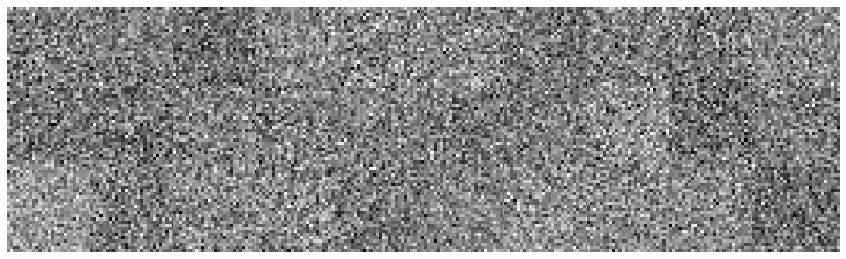

In [9]:
# Thanks to Chris Deotte for this piece of code, https://www.kaggle.com/bhavinmoriya/25-million-images-0-99757-mnist
# PREVIEW IMAGES
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(np.random.randn(28,28),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()